now only motion, no position

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Paths
data_folder = "./time_sets_standardized"

# Load Data
def load_csv_data(folder_path):
    data, labels = [], []
    status_counts = {}  # Dictionary to count files by navigational status
    valid_files = 0  # To track the number of valid files

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))

            # Only consider specific columns: SOG, COG, Heading
            if "Heading" not in df.columns or df["Heading"].isnull().any():
                # Skip this file if "Heading" is missing in any row
                continue

            # Drop the Timestamp column, as it is not needed for training
            features = df[["SOG", "COG", "Heading"]].values
            label = df["Navigational status"].iloc[0]  # Same for the whole file

            # Append data and labels
            data.append(features)
            labels.append(label)
            
            # Track the number of files for each navigational status
            if label not in status_counts:
                status_counts[label] = 0
            status_counts[label] += 1
            
            valid_files += 1

    return np.array(data), np.array(labels), status_counts, valid_files

# Preprocess Data
def preprocess_data(data, labels):
    # Initialize scalers for each feature
    sog_scaler = StandardScaler()
    cog_scaler = StandardScaler()
    heading_scaler = StandardScaler()

    processed_data = []
    for vessel_data in data:
        # Standardize each feature independently across all vessels
        sog = vessel_data[:, 0].reshape(-1, 1)
        cog = vessel_data[:, 1].reshape(-1, 1)
        heading = vessel_data[:, 2].reshape(-1, 1)

        # Apply standardization
        sog = sog_scaler.fit_transform(sog)
        cog = cog_scaler.fit_transform(cog)
        heading = heading_scaler.fit_transform(heading)

        # Calculate rate of change for SOG and COG
        sog_rate_of_change = np.diff(sog, axis=0)
        cog_rate_of_change = np.diff(cog, axis=0)

        # Pad the first time step with zeros for rate of change
        sog_rate_of_change = np.pad(sog_rate_of_change, ((1, 0), (0, 0)), mode='constant')
        cog_rate_of_change = np.pad(cog_rate_of_change, ((1, 0), (0, 0)), mode='constant')

        # Calculate cumulative sum of SOG over time
        sog_cumulative_sum = np.cumsum(sog, axis=0)

        # Add new features to the vessel data
        new_features = np.hstack([sog, cog, heading, sog_rate_of_change, cog_rate_of_change, sog_cumulative_sum])

        processed_data.append(new_features)

    data = np.array(processed_data)
    
    # Encode labels (transform categorical labels to numeric)
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    return data, labels, label_encoder

# Load and preprocess
data, labels, status_counts, valid_files = load_csv_data(data_folder)
data, labels, label_encoder = preprocess_data(data, labels)

# Output the status counts and the number of valid files
print(f"Number of valid files: {valid_files}")
print("Files per Navigational Status:")
for status, count in status_counts.items():
    print(f"{status}: {count} files")

# Compute class weights to handle class imbalance
# class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weight_dict = dict(zip(np.unique(labels), class_weights))

# Define the Bidirectional LSTM Model
n_timesteps, n_features = data.shape[1], data.shape[2]
n_classes = len(np.unique(labels))

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train Model with class weights
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


2024-12-26 10:05:32.475816: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 10:05:32.480517: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 10:05:32.485396: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 10:05:32.503839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735207532.539259   18224 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735207532.54

Number of valid files: 14152
Files per Navigational Status:
Under way using engine: 7944 files
Engaged in fishing: 4429 files
Restricted maneuverability: 386 files
At anchor: 1020 files
Reserved for future amendment [HSC]: 163 files
Constrained by her draught: 20 files
Under way sailing: 80 files
Moored: 110 files


2024-12-26 10:06:50.387088: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 65s 156ms/step - accuracy: 0.5643 - loss: 1.1238 - val_accuracy: 0.5839 - val_loss: 1.0165
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 117s 254ms/step - accuracy: 0.5942 - loss: 1.0065 - val_accuracy: 0.5832 - val_loss: 1.0016
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 140s 248ms/step - accuracy: 0.5911 - loss: 0.9934 - val_accuracy: 0.5832 - val_loss: 0.9958
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 103s 138ms/step - accuracy: 0.5946 - loss: 0.9778 - val_accuracy: 0.5782 - val_loss: 1.0043
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 85s 146ms/step - accuracy: 0.5924 - loss: 0.9654 - val_accuracy: 0.5864 - val_loss: 0.9802
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.6009 - loss: 0.9657 - val_accuracy: 0.5892 - val_loss: 0.9698
Epoch 7/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - accuracy: 0.6031 - loss: 0.9506 - val_accuracy: 0.5910 - val_loss: 0.9702
Epoch 8/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.6021 - loss

89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
Classification Report:
                                     precision    recall  f1-score   support

                          At anchor       0.73      0.60      0.66       218
         Constrained by her draught       0.00      0.00      0.00         4
                 Engaged in fishing       0.46      0.22      0.30       905
                             Moored       0.00      0.00      0.00        30
Reserved for future amendment [HSC]       0.00      0.00      0.00        28
         Restricted maneuverability       0.00      0.00      0.00        74
                  Under way sailing       0.00      0.00      0.00        19
             Under way using engine       0.59      0.84      0.69      1553

                           accuracy                           0.58      2831
                          macro avg       0.22      0.21      0.21      2831
                       weighted avg       0.53      0.58      0.53      2831



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


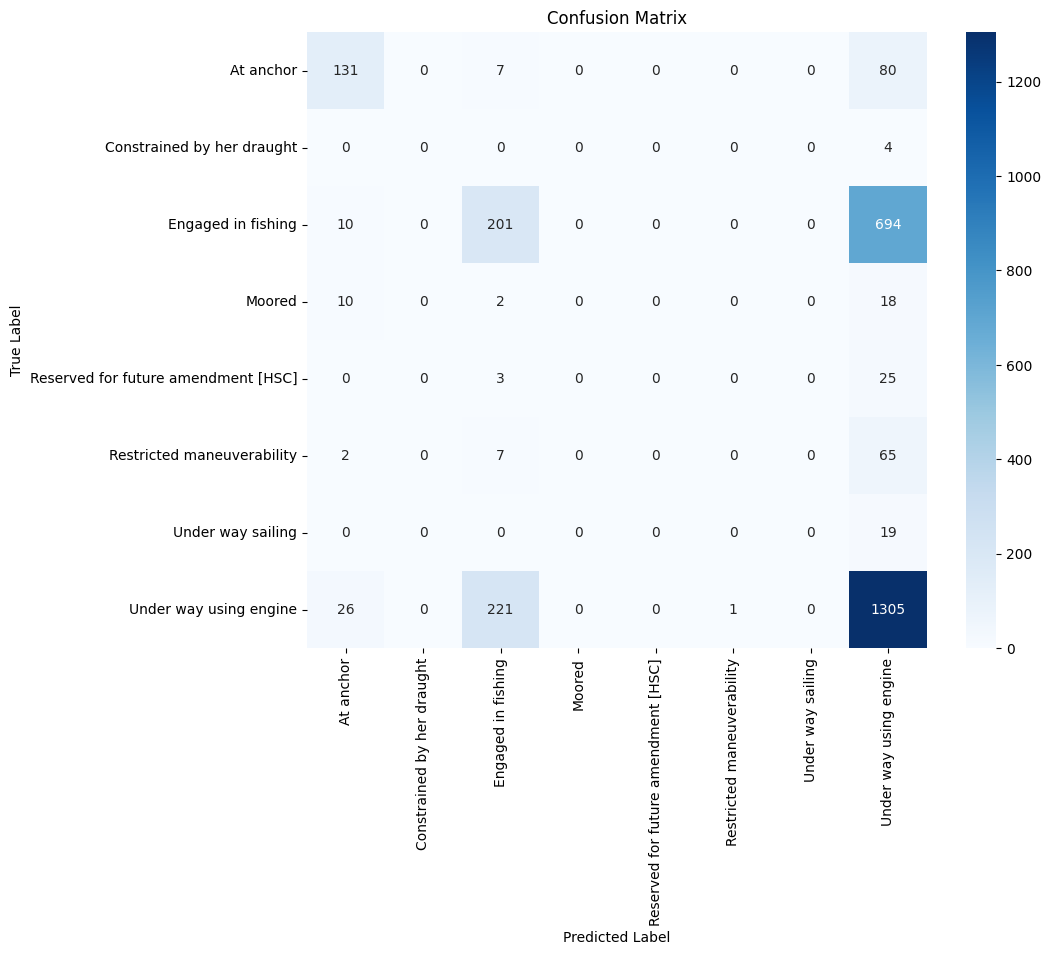

Accuracy: 0.58
Precision: 0.53
Recall: 0.58
F1 Score: 0.53


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall, F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average="weighted")
recall = recall_score(y_test, y_pred_classes, average="weighted")
f1 = f1_score(y_test, y_pred_classes, average="weighted")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
